# Notebook 1

### Query SDSS Data Release 12, save thumbnails to SciDrive

This notebook shows you how to use SciServer compute to communicate with the other components of SciServer. You will learn how to:

1. Connect this notebook with your SciServer login portal account (using a Keystone token)
1. Import special-purpose Python libraries to work with SciServer
1. Use CasJobs to query databases such as the Sloan Digital Sky Survey's Data Release 12 (DR12) database.
1. Write Python code to plot SDSS data in a variety of ways.
1. Store subsets of SDSS data in your private database (MyDB) for later analysis.
1. Use Python to process and analyze your selected data.
1. Store the results of your analysis on a local scratch disk (as an HD5 file) for later reuse.
1. Retrieve thumbnail images for your selected objects from the SDSS Data Archive Server, directly from this notebook using Docker.
1. Save the thumbnails to your SciDrive, where you can easily share them with your colleagues.

# 1. Sign in to SciServer

All SciServer tools (CasJobs, SciDrive, iPython Notebooks, etc.) use the same single-sign-on system, so you only need to remember one password.

When you open your Docker container from the SciServer Compute dashboard page, the current token will be written in the file /home/idies/kestone.token. You can find your token on your Compute dashboard, under your username.

The code block below reads the token and stores it in a local variable, then prints its value along with your login name.

Note: since your token may expire, you should sometimes refresh the token as you work. You can do this by refreshing the token on the Dashboard, and then rerunnning the next block of code.

In [2]:
# This code block defined your token and makes it available as a 
#   system variable for the length of your current session.
# 
# This will usually be the first code block in any script you write.

import SciServer.LoginPortal as Login
token=Login.getToken()
user = Login.getKeystoneUserWithToken(token)
print("Your username is: "+user.userName)
print("Your current token is"+token)

Your username is: gerard
Your current token is15a3406846684c32bbec22c9acc55e82


# 2. Import SciServer libraries 
The SciServer team has written a number of libraries, generally prefixed by <tt>SciServer</tt>, that assist in various functions. As with all Python libraries, they must be actively imported before being used.

The next code block imports those, together with some standard Python libraries helpful for scientific analysis. The code block below applies some settings you may find helpful.

In [3]:
# Step 2a: Import Python libraries to work with SciServer

import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive
import numpy as np                  # standard Python lib for math ops
import pandas                       # graphing package
import matplotlib.pyplot as plt     # another graphing package
import skimage.io                   # image processing library
import urllib                       # parse URLs
import json      # Work with Javascript object notation (.json) files

In [4]:
# Step 2b: Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')

# 3. Query an astronomy database (SDSS DR12)

The next code block searches the SDSS Data Release 12 database via the CasJobs REST API. The query completes quickly, so it uses CasJobs quick mode.

CasJobs also has an asynchronous mode, which will submit job to a queue and will store the results in a table in your MyDB. If your results are very large, it will store the results in MyScratchDB instead.

Run the code block below to query DR12. Try changing some of the query parameters in step 3a to see the effect on the results returned in step 3d.

Documentation on the SciServer Python libraries can be found at our documentation site at:<br />
http://scitest02.pha.jhu.edu/python-docs/

<font color='red'>TODO:</font> make example with batch query mode.

In [5]:
# Step 3a: Find objects in the Sloan Digital Sky Survey's Data Release 12.
# Queries the Sloan Digital Sky Serveys' Data Release 12.
# For the database schema and documentation see http://skyserver.sdss.org
#
# This query finds "a 4x4 grid of nice-looking galaxies": 
#   galaxies in the SDSS database that have a spectrum 
#   and have a size (petror90_r) larger than 10 arcsec.
# 
# First, store the query in an object called "query"
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""

In [6]:
# Step 3b: Send the query to CasJobs.
#   WHAT PARAMETERS DOES CasJobs.executeQuery take?
# This example uses DR12 as context - the code makes a connection 
#   to the DR12 database, then runs the query in quick mode.
#   When the query succeeds, an "OK" message prints below.
queryResponse = CasJobs.executeQuery(query, "dr12",token=token)

In [7]:
# Step 3c: store results in a format for easy analysis.
#
# Results have been returned as a CSV table called "queryResponse".
# Now parse the results into a DataFrame object using 
#    the pandas library.
#    pandas.read_csv documentation: 
#      http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
#    INSERT LINK to documentation on how to use pandas.read_csv.
gals = pandas.read_csv(queryResponse, index_col='objId')

In [8]:
# Step 3d: Show the table of results
gals

,objId,ra,dec,petror90_r
0,1237645941824356443,40.285690,-0.714957,14.72862
1,1237645943978393694,55.123625,0.872487,18.85110
2,1237645943979114622,56.847420,0.875488,15.66479
3,1237645943979311221,57.248385,0.925979,14.60275
4,1237646588246688297,80.135126,1.186679,11.14294
5,1237648672921485632,243.708876,-0.915653,15.01578
6,1237648672922337955,245.700633,-0.844301,10.51866
7,1237648672922468973,246.015172,-0.902869,10.80825
8,1237648673459077169,245.367353,-0.457074,11.18379
9,1237648673459667002,246.695626,-0.510111,10.27149


## Exercise A: Querying CasJobs

### Here is everything you've seen so far, in one code block.

### Try changing the query in the following ways. What changes do you notice in the table of returned results?  

1. Return 8 matching objects insetad of 16.
1. Select only nearby galaxies (redshift < 0.05).
1. Select only galaxies likely to be spirals (with u-r color >= 2.22)
1. Search for galaxies in SDSS Data Release 10 instead of DR12.

#### Some helpful resources
SciServer Python modules documentation:
http://scitest02.pha.jhu.edu/python-docs/

Schema of SDSS Data Release 12:
http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx 

Schema of SDSS Data Release 10:
http://skyserver.sdss.org/dr10/en/help/browser/browser.aspx

In [41]:
# Here is everything so far, from beginning to end.
# import your token
import SciServer.Keystone as Keystone  # import user management library to print username
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
# import packages
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive
import numpy as np                  # standard Python lib for math ops
import pandas                       # graphing package
import matplotlib.pyplot as plt     # another graphing package
import skimage.io                   # image processing library
import urllib                       # parse URLs
import json      # Work with Javascript object notation (.json) file
pandas.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
# enter query
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
# send query to CasJobs
queryResponse = CasJobs.executeQuery(query, "dr12",token=token)
# store results
gals = pandas.read_csv(queryResponse)
# show results
gals

executeQuery POST response:  200 OK


,objId,ra,dec,petror90_r
0,1237645941824356443,40.285690,-0.714957,14.72862
1,1237645943978393694,55.123625,0.872487,18.85110
2,1237645943979114622,56.847420,0.875488,15.66479
3,1237645943979311221,57.248385,0.925979,14.60275
4,1237646588246688297,80.135126,1.186679,11.14294
5,1237648672921485632,243.708876,-0.915653,15.01578
6,1237648672922337955,245.700633,-0.844301,10.51866
7,1237648672922468973,246.015172,-0.902869,10.80825
8,1237648673459077169,245.367353,-0.457074,11.18379
9,1237648673459667002,246.695626,-0.510111,10.27149


# 4. Make a simple Plot

Now that we have run the query and stored the results, we can start analyzing the results.

Start by making a simple plot of positions, using the default query from step 3 
(select top 16... AND p.petror90_r > 10).

What do you see?

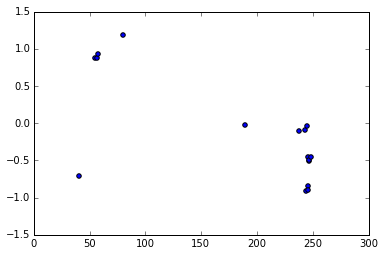

In [10]:
plt.scatter(gals['ra'], gals['dec'])
plt.show() 

## Exercise B: Plotting data

### Here is everything you've seen so far, including the plots, in one code block.

### Try changing the code block below in the following ways. What changes do you notice in the plots?  

1. Plot the first 100 matching objects instead of the first 16.
1. Plot galaxies out to dec = +/-5 (change the display axes as well)
1. Plot a color-magnitude diagram with g on the x-axis and g-r on the y-axis.

#### Some helpful resources
SciServer Python modules documentation:
http://scitest02.pha.jhu.edu/python-docs/

Schema of SDSS Data Release 12:
http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx 

Documentation for matplotlib module:
http://matplotlib.org/contents.html

executeQuery POST response:  200 OK


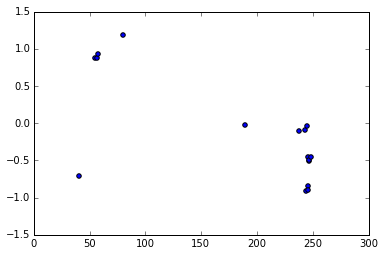

In [15]:
# Here is everything so far, from beginning to end.
# import your token
import SciServer.Keystone as Keystone  # import user management library to print username
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
# import packages
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive
import numpy as np                  # standard Python lib for math ops
import pandas                       # graphing package
import matplotlib.pyplot as plt     # another graphing package
import skimage.io                   # image processing library
import urllib                       # parse URLs
import json      # Work with Javascript object notation (.json) file
pandas.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
# enter query
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
# send query to CasJobs
queryResponse = CasJobs.executeQuery(query, "dr12",token=token)
# store results
gals = pandas.read_csv(queryResponse)
# make scatterplot
plt.scatter(gals['ra'], gals['dec'])
plt.show() 

# 5. Store results in your container for later use

The next Code block saves the data table "gals" as an HD5 file and as a CSV file.

To see these files, go back to your iPython notebook dashboard (the page from which you 
opened this notebook). Make sure you are in the <b>persistent</b> folder. You should see your files there. Click on the file names to preview.

In [11]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')

## Exercise C: Saving files

### Using the code block below (a copy of the one above), try the following:

1. Change the name of the file
1. Save the file as tab-separated variable (.tsv) instead of the default comma-separated variable (.csv).

Documentation on the Pandas package's DataFrame.to_csv method:<br />
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html

In [3]:
# store result as HDF5 file 
h5store = pandas.HDFStore('GalaxyThumbSample.h5')
h5store['galaxies']=gals
h5store.close()

# store result as CSV file
gals.to_csv('GalaxyThumbSample.csv')

# 6. Retrieve thumbnail cutouts of galaxies and show them on screen
SkyServer has a service that will produce a color image cutout of certain dimensions around a specified position, displayed as a JPG thumbnail. 

The service creates the thumbnail using a pre-defined image pyramid. For a single image, you can construct the URL of the service using your query results, then use the skimage package to call the URL. To get all thumbnails in your query result, you can iterate using a loop.

The code block below gives an example of how to retrieve JPG thumbnails of galaxies in DR12. Take a look at each line in the <code>for</code> loop. What does each line do? How would you modify it to display results differently?

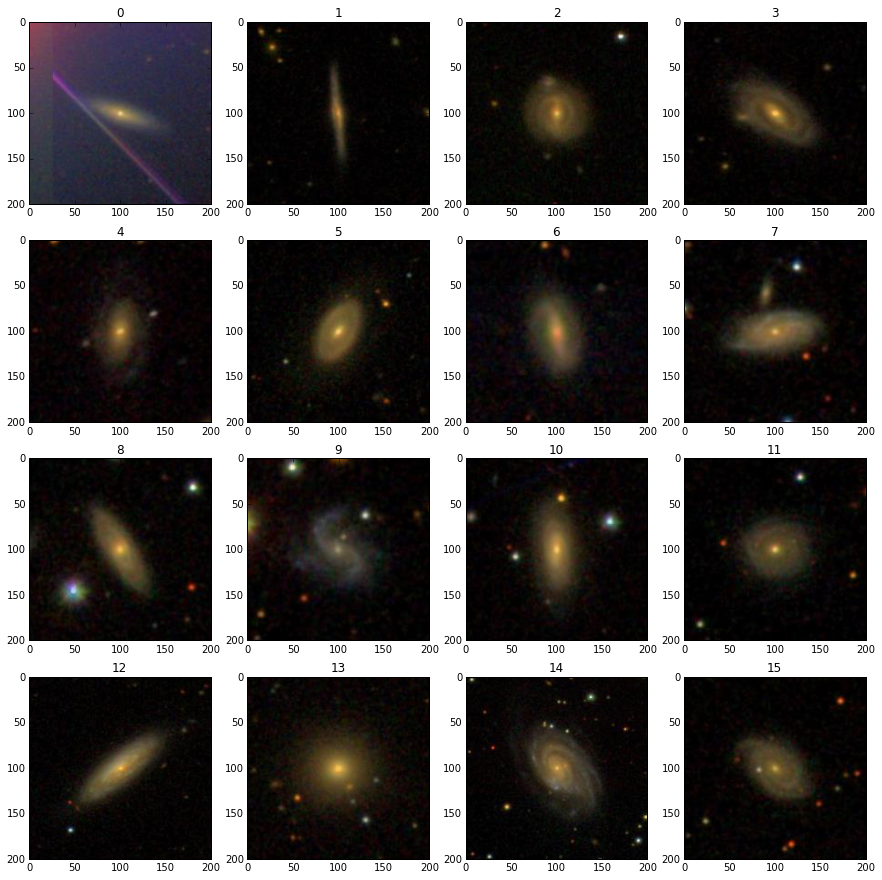

In [12]:
width=200
height=200
pixelsize=0.396
plt.figure(figsize=(15, 15))
subPlotNum = 1

for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    img=skimage.io.imread(url)
    plt.subplot(4,4,subPlotNum)
    subPlotNum += 1
    plt.imshow(img)
    # show the object identifier (objId) above the image.
    plt.title(index)


# 7. Write thumbnails to SciDrive

SciDrive is the newest component of SciServer. It allows you to save query results as flat files in a Dropbox-like interface you can access anywhere.

For boring technical reasons, the version of SciDrive this notebook connects to is not the same as the pre-production version you may have used before. Use the link below to access this test version of SciDrive. You should have no containers in this SciDrive yet.

Check your test SciDrive at:<br />
http://scitest09.pha.jhu.edu/scidrive/scidrive.html

If the above link does not show a proper view of scidrive, with folders etc., please let us know, and do not run the rest of the code in this notebook until we investigate.

The three code blocks below work together to write the thumbnails you generated in step 6 into your test SciDrive.

In [13]:
# Step 7a: generate a public URL to be used by SciDrive
# TODO should ba part of the SciServer.SciDrive library
def scidrivePublicURL(path):
    req = urllib.request.Request(url=SciServer.Config.SciDriveHost+'/vospace-2.0/1/media/sandbox/'+path,method='GET') 
    req.add_header('X-Auth-Token', token) 
    req.add_header('Content-Type','application/xml') 
    res=urllib.request.urlopen(req)
    jsonResponse = json.loads(res.read().decode())
    return jsonResponse['url']

In [14]:
# Step 7b: create a container in your SciDrive to hold the thumbnail images
container = 'thumbnails25april'
# IMPORTANT: Only run next if the container does not yet exist. If you have already created 
#   the container, comment out the next line.
#SciServer.SciDrive.createContainer(container,token=token)

In [15]:
# Step 7c: Write thumbnails to SciDrive. You will see a confirmation message below
#   for each thumbnail.
width=200
height=200
pixelsize=0.396

puburls=[]
for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    req = urllib.request.Request(url=url,method='GET')
    res = urllib.request.urlopen(req)
    data=res.read()
    scidrivename_name = container+"/new_"+str(index)+".jpg"
# Here the file gets uploaded to the container
    SciServer.SciDrive.upload(scidrivename_name, data,token=token)
    puburls.append(scidrivePublicURL(scidrivename_name))
gals['pubURL']=puburls

# print the URL of the first thumbnail as a final confirmation message.
print("URL of first thumbnail: "+puburls[0])

{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4034,"modified":"Mon, 25 Apr 2016 13:32:57 -0400","path":"/thumbnails25april/new_0.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.6 KB","rev":1,"thumb_exists":false,"bytes":3658,"modified":"Mon, 25 Apr 2016 13:32:58 -0400","path":"/thumbnails25april/new_1.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"4.2 KB","rev":1,"thumb_exists":false,"bytes":4266,"modified":"Mon, 25 Apr 2016 13:33:01 -0400","path":"/thumbnails25april/new_2.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.7 KB","rev":1,"thumb_exists":false,"bytes":3761,"modified":"Mon, 25 Apr 2016 13:33:02 -0400","path":"/thumbnails25april/new_3.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4036,"modified":"Mon, 25 Apr 2016 13:33:04 -0400","path":"/thumbna

Now check your test SciDrive again. You should see a container called "thumbnails".

Double-click on the name to open the container. You should see the thumbnails you just saved!

Your test SciDrive URL:<br />
http://scitest09.pha.jhu.edu/scidrive/scidrive.html

## Exercise D: Creating and saving thumbnails

### The code block below shows everything you have done so far. Try changing it in the following ways. What changes result?

1. Plot the first 100 matching objects instead of the first 16.
1. Plot galaxies out to dec = +/-5 (change the display axes as well)
1. Plot a color-magnitude diagram with g on the x-axis and g-r on the y-axis.

#### Some helpful resources
SciServer Python modules documentation:
http://scitest02.pha.jhu.edu/python-docs/

Schema of SDSS Data Release 12:
http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx 

Documentation for matplotlib module:
http://matplotlib.org/contents.html

Documentation on the Pandas package's DataFrame.to_csv method:<br />
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html

In [17]:
# Here is everything so far, from beginning to end.
# import your token
import SciServer.Keystone as Keystone  # import user management library to print username
with open('/home/idies/keystone.token', 'r') as f:
    token = f.read().rstrip('\n')
# import packages
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive           # read/write to/from SciDrive
import numpy as np                  # standard Python lib for math ops
import pandas                       # graphing package
import matplotlib.pyplot as plt     # another graphing package
import skimage.io                   # image processing library
import urllib                       # parse URLs
import json      # Work with Javascript object notation (.json) file
pandas.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
# enter query
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 19.6
  AND p.g BETWEEN 0 AND 17
  AND p.petror90_r > 10
"""
# send query to CasJobs
queryResponse = CasJobs.executeQuery(query, "dr12",token=token)
# store results
gals = pandas.read_csv(queryResponse)

# Step 7a: generate a public URL to be used by SciDrive
# TODO should ba part of the SciServer.SciDrive library
def scidrivePublicURL(path):
    req = urllib.request.Request(url=SciServer.Config.SciDriveHost+'/vospace-2.0/1/media/sandbox/'+path,method='GET') 
    req.add_header('X-Auth-Token', token) 
    req.add_header('Content-Type','application/xml') 
    res=urllib.request.urlopen(req)
    jsonResponse = json.loads(res.read().decode())
    return jsonResponse['url']
# Step 7b: create a container in your SciDrive to hold the thumbnail images
container = 'thumbnails'
# IMPORTANT: Only run next if the container does not yet exist. If you have already created 
#   the container, comment out the next line.
#SciServer.SciDrive.createContainer(container,token=token)
# Step 7c: Write thumbnails to SciDrive. You will see a confirmation message below
#   for each thumbnail.
width=200
height=200
pixelsize=0.396

puburls=[]
for index,gal in gals.iterrows():
    scale=2*gal['petror90_r']/pixelsize/width
    url="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url+="&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url+="&height="+str(height)
    req = urllib.request.Request(url=url,method='GET')
    res = urllib.request.urlopen(req)
    data=res.read()
    scidrivename_name = container+"/new_"+str(index)+".jpg"
# Here the file gets uploaded to the container
    SciServer.SciDrive.upload(scidrivename_name, data,token=token)
    puburls.append(scidrivePublicURL(scidrivename_name))
gals['pubURL']=puburls

# print the URL of the first thumbnail as a final confirmation message.
print("URL of first thumbnail: "+puburls[0])


executeQuery POST response:  200 OK
{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4034,"modified":"Mon, 25 Apr 2016 13:35:14 -0400","path":"/thumbnails/new_0.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.6 KB","rev":1,"thumb_exists":false,"bytes":3658,"modified":"Mon, 25 Apr 2016 13:35:15 -0400","path":"/thumbnails/new_1.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"4.2 KB","rev":1,"thumb_exists":false,"bytes":4266,"modified":"Mon, 25 Apr 2016 13:35:17 -0400","path":"/thumbnails/new_2.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.7 KB","rev":1,"thumb_exists":false,"bytes":3761,"modified":"Mon, 25 Apr 2016 13:35:18 -0400","path":"/thumbnails/new_3.jpg","is_dir":false,"icon":"file","root":"dropbox","mime_type":"application/file"}
{"size":"3.9 KB","rev":1,"thumb_exists":false,"bytes":4036,"modified":"Mon, 25 Apr 2016 13:35:19 -0400","path":"

# 8. Store all results in a table in your MyDB

So far, you have found data about some galaxies in SDSS Data Release 12. In addition to the data that DR12 
provides, you have also used SciServer libraries to find thumbnail images for each galaxy. Now, you will store all this information in a new table in your CasJobs "MyDB" personal database space.

Remember that all the data you queried from DR12 is now stored in a PANDAS data frame called "gals". You'll be starting from that data frame to save your results in your MyDB.

You can see what is currently in your MyDB here:<br />http://scitest02.pha.jhu.edu/CasJobs/MyDB.aspx

In [27]:
# Step 8a: First, add another column to the data frame to give a link to the thumbnails you saved into SciDrive.
gals['pubURL']=puburls
# print out the data frame to verify that the new column has been added.
gals

,objId,ra,dec,petror90_r,pubURL
index,,,,,
0,1237645941824356443,40.285690,-0.714957,14.72862,http://scitest09.pha.jhu.edu/vospace-2.0/data/6d83213f-a7d2-45c3-9933-66227d02e5a6
1,1237645943978393694,55.123625,0.872487,18.85110,http://scitest09.pha.jhu.edu/vospace-2.0/data/a625688a-4867-4b03-a09c-84dbc1412236
2,1237645943979114622,56.847420,0.875488,15.66479,http://scitest09.pha.jhu.edu/vospace-2.0/data/0bf08181-5e8f-4abb-8c65-73155ba158bd
3,1237645943979311221,57.248385,0.925979,14.60275,http://scitest09.pha.jhu.edu/vospace-2.0/data/ce80afec-5f83-4d1b-9a83-0fd1a56ffe99
4,1237646588246688297,80.135126,1.186679,11.14294,http://scitest09.pha.jhu.edu/vospace-2.0/data/bf814d9c-aa3d-4e86-93c3-a56d9cbbfb34
5,1237648672921485632,243.708876,-0.915653,15.01578,http://scitest09.pha.jhu.edu/vospace-2.0/data/16a95971-7503-46fa-bbce-d3cdd70d6d3a
6,1237648672922337955,245.700633,-0.844301,10.51866,http://scitest09.pha.jhu.edu/vospace-2.0/data/1fb733f3-75ea-4fd3-9431-b7a969bcd92a
7,1237648672922468973,246.015172,-0.902869,10.80825,http://scitest09.pha.jhu.edu/vospace-2.0/data/974694d5-b6ce-40fe-ba55-c88fad411219
8,1237648673459077169,245.367353,-0.457074,11.18379,http://scitest09.pha.jhu.edu/vospace-2.0/data/15352715-69c8-4aef-ab3f-cfe917b57dc9


In [28]:
# Step 8b: create a new table in your MyDB to hold your results.
# You can create a new table using the SQL "CREATE TABLE" statement. Note that you must specify the 
#    columns correctly before you try to write data into the table.
#    If you want to save the data into an existing table instead, skip this step - just make sure that the 
#    schema of the existing table matches the structure of the data frame.
ddl = """CREATE TABLE GalaxyThumbs2(objId bigint, ra real, dec real, petror90_r real, pubURL varchar(128))"""
response = SciServer.CasJobs.executeQuery(ddl,token=token)


executeQuery exception message:  HTTP Error 500: InternalServerError {"Error Code":500,"Error Type":"InternalServerError","Error Message":"Failed to execute a query: There is already an object named 'GalaxyThumbs2' in the database.","LogMessageID":"52e4966f-e19c-4ced-a466-59683ad424af"}


In [29]:
# Step 8c: upload data from the Data Frame directly into the MyDB table you just created.
response=SciServer.CasJobs.uploadPandasDataFrameToTable(gals,"GalaxyThumbs2",token=token)
# upload directly from DataFrame
#response=SciServer.CasJobs.uploadCVSDataToTable(gals.to_csv().strip().encode("utf8"),"GalaxyThumbs",token=token)


Uploading  2485 bytes...
There was a problem uploading the data. Exception message:  b'{"Error Code":500,"Error Type":"InternalServerError","Error Message":"Failed to upload table data: Import columns do not match existing schema in \'GalaxyThumbs2\'","LogMessageID":"5c141437-ef5c-4945-b95a-6f0f54553120"}'


See the results in your MyDB at: http://scitest02.pha.jhu.edu/CasJobs/MyDB.aspx
